In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_points_on_sphere(N, R):
    """Generate N points on a sphere of radius R."""
    points = []
    for i in range(N):
        theta = np.random.uniform(0, 2 * np.pi)
        phi = np.arccos(np.random.uniform(-1, 1))
        x = R * np.sin(phi) * np.cos(theta)
        y = R * np.sin(phi) * np.sin(theta)
        z = R * np.cos(phi)
        points.append([x, y, z])
    return np.array(points)


def generate_points_in_sphere(N, R):
    """Generate N points in a sphere of radius R."""
    points = []
    for i in range(N):
        r = R * np.random.uniform(0, 1) ** (1 / 3)
        theta = np.random.uniform(0, 2 * np.pi)
        phi = np.arccos(np.random.uniform(-1, 1))
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        points.append([x, y, z])
    return np.array(points)

In [3]:
def plot_points(points):
    """Plot points on a sphere."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("equal")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    for x, y, z in points:
        ax.scatter(x, y, z)
    plt.show()


def plot_two_figures(figure1, figure2):
    """Plot points of two figures."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z in figure1:
        ax.scatter(x, y, z, c='r')
    for x, y, z in figure2:
        ax.scatter(x, y, z, c='b')
    plt.show()

In [4]:
CONTAINER_NAME = 'IVHD'

In [5]:
def prepare_labels_and_data(p1, p2):
    labels = np.concatenate((np.zeros(len(p1)), np.ones(len(p2))), dtype=float)
    data = np.concatenate((p1, p2), dtype=float)

    np.savetxt('labels.csv', labels, delimiter=',', fmt='%f')
    np.savetxt('data.csv', data, delimiter=',', fmt='%f')


def upload_labels_and_data():
    !docker cp labels.csv "{CONTAINER_NAME}:/opt/viskit/labels.csv"
    !docker cp data.csv "{CONTAINER_NAME}:/opt/viskit/data.csv"


def calculate_knn_graph(nn, is_cosine_metric):
    !docker exec -it {CONTAINER_NAME} python3 "/opt/viskit/python/viskit/knn_graph/faiss_generator.py" "/opt/viskit/data.csv" {is_cosine_metric} {nn} "/opt/viskit/graph.bin"


def run_viskit(iterations, nearest_neighbors_count, random_neighbors_count, caster_name, binary_distances):
    binary_distances_int = 1 if binary_distances else 0
    reverse_neighbors_steps = 0
    reverse_neighbors_count = 0
    l1_steps = 0

    !docker exec -it {CONTAINER_NAME} "/opt/viskit/viskit_offline/viskit_offline" "/opt/viskit/data.csv" "/opt/viskit/labels.csv" "/opt/viskit/graph.bin" "/opt/viskit/output.csv" {iterations} {nearest_neighbors_count} {random_neighbors_count} {binary_distances_int} {reverse_neighbors_steps} {reverse_neighbors_count} {l1_steps} {caster_name}


def load_viskit_output():
    !docker cp "{CONTAINER_NAME}:/opt/viskit/output.csv" output.csv
    output = np.loadtxt('output.csv', delimiter=',')
    return output


def cleanup():
    !docker exec -it {CONTAINER_NAME} rm "/opt/viskit/data.csv" "/opt/viskit/labels.csv" "/opt/viskit/graph.bin" "/opt/viskit/output.csv"
    !rm data.csv labels.csv output.csv

In [6]:
from IPython.utils import io


def ivhd(p1, p2, iterations=2500, nearest_neighbors_count=2, random_neighbors_count=1, caster_name="force-directed",
         graph_nn=100, graph_is_cosine_metric=True, capture_output=True, return_result=False, plot_result=True,
         binary_distances=False):
    def run_ihvd():
        prepare_labels_and_data(p1, p2)
        upload_labels_and_data()
        calculate_knn_graph(graph_nn, graph_is_cosine_metric)
        run_viskit(iterations, nearest_neighbors_count, random_neighbors_count, caster_name, binary_distances)
        result = load_viskit_output()
        cleanup()
        return result

    if capture_output:
        with io.capture_output() as _:
            output = run_ihvd()
    else:
        output = run_ihvd()

    if plot_result:
        colors = ["red" if x == 0 else "blue" for x in output[:, 2]]
        plt.scatter(output[:, 0], output[:, 1], color=colors)
        plt.show()

    if return_result:
        return output


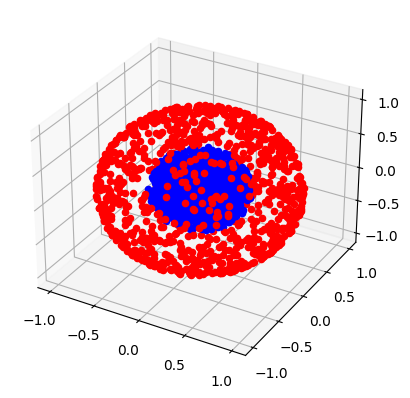

In [7]:
R = 1
N = 1000
on_sphere_points = generate_points_on_sphere(N, R)
in_sphere_points = generate_points_in_sphere(N, .5 * R)
plot_two_figures(on_sphere_points, in_sphere_points)

Preparing to copy...Copying to container - 0BSuccessfully copied 20kB to IVHD:/opt/viskit/labels.csv
Preparing to copy...Copying to container - 0BSuccessfully copied 58.9kB to IVHD:/opt/viskit/data.csv
Searching...
Finished.
0:00:00.006898
[Info] [CSV Parser] Loading dataset from file: /opt/viskit/data.csv
[Info] [CSV Parser] Loading labels from file: /opt/viskit/labels.csv
[Info] [CSV Parser] Labels file passed.
[Info] [CSV Parser] Dataset size: 2000
[Info] [CSV Parser] Dataset dimensionality: 3
[Info] [CSV Parser] Number of classes in dataset: 2
[Info] [CSV Parser] Finished.
[Info] [Graph] Loading graph from cache...
[Info] [Graph] Using regular distances...
[Info] [Graph] Finished.
[Info] [kNN Generator] Determining random neighbors...
[Info] [kNN Generator] Finished.
[Info] [kNN Generator] Neighbors in graph: 24000
Preparing to copy...Copying from container - 0BSuccessfully copied 44kB to /Users/ryszard.precikowski/s8/wizualizacje/ivhd_test/output.csv


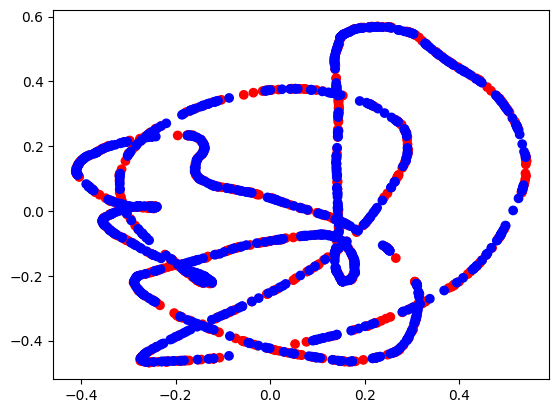

In [8]:
ivhd(on_sphere_points, in_sphere_points, iterations=5000, nearest_neighbors_count=10, random_neighbors_count=2,
     graph_nn=100, capture_output=False, graph_is_cosine_metric=False, caster_name="adam")

In [9]:
def generate_points_in_torus(N, R, r, horizontal=True, center=(0, 0, 0)):
    """Generate N points in a torus (vertical or horizontal) with major radius R, minor radius r with given center."""
    points = []
    for i in range(N):
        theta = np.random.uniform(0, 2 * np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        x0, y0, z0 = center
        x = (R + r * np.cos(phi)) * np.cos(theta) + x0
        y = (R + r * np.cos(phi)) * np.sin(theta) + y0
        z = r * np.sin(phi) + z0
        if horizontal:
            points.append([x, y, z])
        else:
            points.append([x, z, y])
    return np.array(points)

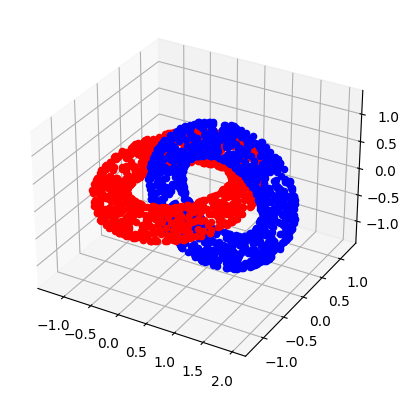

In [10]:
horizontal_torus_points = generate_points_in_torus(1000, 1, 0.25)
vertical_torus_points = generate_points_in_torus(1000, 1, 0.25, horizontal=False, center=(0.75, 0, 0))
plot_two_figures(horizontal_torus_points, vertical_torus_points)


Preparing to copy...Copying to container - 0BSuccessfully copied 20kB to IVHD:/opt/viskit/labels.csv
Preparing to copy...Copying to container - 0BSuccessfully copied 58.4kB to IVHD:/opt/viskit/data.csv
Searching...
Finished.
0:00:00.006350
[Info] [CSV Parser] Loading dataset from file: /opt/viskit/data.csv
[Info] [CSV Parser] Loading labels from file: /opt/viskit/labels.csv
[Info] [CSV Parser] Labels file passed.
[Info] [CSV Parser] Dataset size: 2000
[Info] [CSV Parser] Dataset dimensionality: 3
[Info] [CSV Parser] Number of classes in dataset: 2
[Info] [CSV Parser] Finished.
[Info] [Graph] Loading graph from cache...
[Info] [Graph] Using regular distances...
[Info] [Graph] Finished.
[Info] [kNN Generator] Determining random neighbors...
[Info] [kNN Generator] Finished.
[Info] [kNN Generator] Neighbors in graph: 30000
Preparing to copy...Copying from container - 0BSuccessfully copied 43.5kB to /Users/ryszard.precikowski/s8/wizualizacje/ivhd_test/output.csv


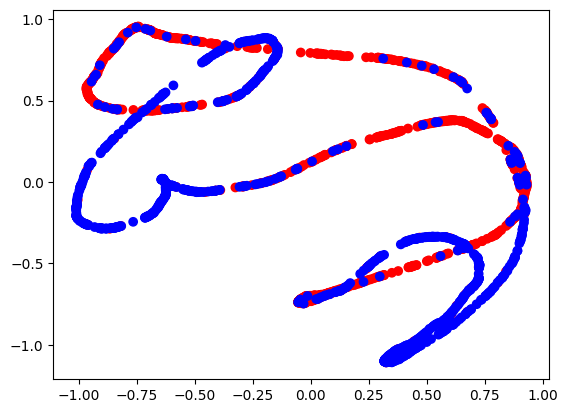

In [11]:
ivhd(horizontal_torus_points, vertical_torus_points, iterations=5000, nearest_neighbors_count=10,
     random_neighbors_count=5,
     graph_nn=100, capture_output=False, graph_is_cosine_metric=False, caster_name="adam")